In [1]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

import scipy.stats
from scipy.stats import mannwhitneyu
import math
from matplotlib.lines import Line2D

import plot
import calculate

%matplotlib inline

In [2]:
#this defines the criterion which we use to filter authors
CAREER_LENGTH = 1
# this defines how long we follow each cohort
MAX_CAREER_LENGTH_COHORT = 15
END_YEAR = 2018    

### Read authors with start and end year details

In [3]:
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')

In [4]:
print("authorStartEndCareerData: ", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData.head())

#print(authorStartEndCareerData[authorStartEndCareerData['author'] == 'donatella sciuto'])
authorStartEndCareerData.rename(columns={'num_pub':'total_num_pub'}, inplace=True)

authorStartEndCareerData:  1699352


In [5]:
authorStartEndCareerData.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence,avg_absence,dropped_after_10,gender,early_career_qual,early_career_recognition,succ_after_15y,early_career_prod
0,'maseka lesaoana,2001,2015,2,15,14,7.5,True,none,23.0,5.0,23.0,1
1,(max) zong-ming cheng,2009,2011,2,3,13,7.5,True,none,4.0,4.0,4.0,2
2,(zhou) bryan bai,2011,2012,2,2,14,7.5,True,none,0.0,0.0,0.0,2
3,a aart blokhuis,1992,2005,2,14,13,7.5,True,none,0.0,0.0,0.0,1
4,a ahrabian,2017,2017,1,1,15,15.0,True,none,0.0,0.0,0.0,1


### Read Publication data

In [6]:
authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-'+str(CAREER_LENGTH)+'-year.csv')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count().reset_index()
author_year_numPub = author_year_numPub.rename(columns={'pub_id':'num_pub'})

print("authorPublicationData: ", authorPublicationData.shape[0])

authorPublicationData.head()

authorPublicationData:  9413377


,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [7]:
author_year_numPub.head()

,author,year,num_pub
0,'maseka lesaoana,2001,1
1,'maseka lesaoana,2015,1
2,(max) zong-ming cheng,2009,1
3,(max) zong-ming cheng,2011,1
4,(zhou) bryan bai,2011,1


In [8]:
authorPublicationData[authorPublicationData["author"] == "'maseka lesaoana"]

,author,year,pub_id
4543408,'maseka lesaoana,2015,2a10f544-51ac-4261-8a26-cf61c1abdc03
4896492,'maseka lesaoana,2001,4ff8ca7b-16b7-4bc8-b235-1eeac9b2aefa


## Early career

In [ ]:
from matplotlib.lines import Line2D

zscore = True
numcols = 5
start_range = 1980
end_range = 2000
cells = end_range - start_range
numrows = int(cells/numcols)

var = "prod" # can also be qual

results = pd.DataFrame(columns=["year", "num_obs", "group", "slope", "intercept", "r_value", "p_value", "std_err"])
fig, ax = plt.subplots(nrows=numrows, ncols=numcols, sharex=False, sharey=False, figsize=(20,15))


custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4)]
for year in range(start_range, end_range):
    data = authorStartEndCareerData[authorStartEndCareerData.year == year]
    x = data['early_career_prod']
    
    
    if(zscore):
        y = (data['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y = data['succ_after_15y']/np.sum(data['succ_after_15y'])
   
    x_f = data[data.gender == 'f']['early_career_prod']
    if(zscore):
        y_f = (data[data.gender == 'f']['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y_f = data[data.gender == 'f']['succ_after_15y']/np.sum(data['succ_after_15y'])
    
    x_m = data[data.gender == 'm']['early_career_prod']
    if(zscore):
        y_m = (data[data.gender == 'm']['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y_m = data[data.gender == 'm']['succ_after_15y']/np.sum(data['succ_after_15y'])
    

    axes = ax[(year-start_range)//numcols,year%start_range%numcols]
    axes.scatter(x, y, color="black")
    axes.scatter(x_m, y_m, color="blue")
    axes.scatter(x_f, y_f, color="red")
    fit = np.polyfit(x, y, deg=1)
    fit_f = np.polyfit(x_f, y_f, deg=1)
    fit_m = np.polyfit(x_m, y_m, deg=1)
    #axes.plot(x, fit[0] * x + fit[1], color='black')
    axes.plot(x_f, fit_f[0] * x_f + fit_f[1], color='red')
    axes.plot(x_m, fit_m[0] * x_m + fit_m[1], color='blue')
    axes.set_title("Cohort: " + str(year))
    # plt.xlim(0, 50)
    # plt.ylim(0,200)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    results = results.append({"year":year, "num_obs":len(x), "group":"all", "slope":slope, "intercept":intercept, 
                              "r_value":r_value, "p_value":p_value, "std_err":std_err}, ignore_index=True)
    
    m_slope, m_intercept, m_r_value, m_p_value, m_std_err = scipy.stats.linregress(x_m, y_m)
    results = results.append({"year":year, "num_obs":len(x_m), "group":"men", "slope":m_slope, "intercept":m_intercept, 
                              "r_value":m_r_value, "p_value":m_p_value, "std_err":m_std_err}, ignore_index=True)
    f_slope, f_intercept, f_r_value, f_p_value, f_std_err = scipy.stats.linregress(x_f, y_f)
    results = results.append({"year":year, "num_obs":len(x_f), "group":"women", "slope":f_slope, "intercept":f_intercept, 
                              "r_value":f_r_value, "p_value":f_p_value, "std_err":f_std_err}, ignore_index=True)
    
    #print(slope, intercept)
    #axes.add_artist(axes.legend("R squared: " + str(r_value), loc=2))
    axes.annotate("R squared: " + str(np.round(r_value, decimals=3))+"\nSlope: "+str(np.round(slope, decimals=3)), xy=(0.01,0.8), xycoords='axes fraction', fontsize=14)
    #axes.legend(custom_lines, ['Female', 'Male', 'All'], loc=1)
fig.text(0.5, 0.1, 'Early Career Productivity', ha='center', va='center')
fig.text(0.06, 0.5, 'Final Success', ha='center', va='center', rotation='vertical')
plt.show()
if(zscore):
    fig.savefig("fig/earlycareer_"+str(var)+"_final_success_zscore.png", edgecolor='none', bbox_inches='tight')
else:
    fig.savefig("fig/earlycareer_"+str(var)+"_final_success.png", edgecolor='none', bbox_inches='tight')

print(results.head())
if(zscore):
    results.to_csv("fig/earlycareer_"+str(var)+"_final_success_zscore.csv")
else:
    results.to_csv("fig/earlycareer_"+str(var)+"_final_success.csv")

In [ ]:
results[results.year==1985]

In [ ]:
for group in ['all', 'men', 'women']:
    temp = results[results.group == group]
    plt.plot(temp['year'], temp['r_value'], label=group)
plt.xlabel("Year")
plt.ylabel("R squared (productivity and success)")
plt.title("R squared over cohorts for " + group)
plt.ylim((0,0.6))
plt.legend()
plt.show()

In [ ]:
for group in ['all', 'men', 'women']:
    temp = results[results.group == group]
    plt.plot(temp['year'], temp['slope'], label=group)
plt.xlabel("Year")
plt.ylabel("Slope (productivity and success)")
plt.title("Slope over cohorts for " + group)
plt.legend()
plt.show()

In [ ]:
results.head()

## Publications analysis

In [9]:
author_year_numPub = author_year_numPub.merge(authorStartEndCareerData[['author','start_year', 'gender']], on="author")

groupByYearData = calculate.calculate_cumulative_for_authors(author_year_numPub, 'num_pub')

years = groupByYearData['year'].unique()
years = sorted(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]

In [15]:
step = 3
cohort_start_years = list(range(years[0], END_YEAR - MAX_CAREER_LENGTH_COHORT + step, step))
skip_overlaping_years = False

In [11]:
print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
print(groupByYearData[groupByYearData['author'] == '(max) zong-ming cheng'].head(10))

         year            author  num_pub  start_year gender  cum_num_pub
733467   2001  'maseka lesaoana        1        2001   none            1
4142431  2015  'maseka lesaoana        1        2001   none            2
         year                 author  num_pub  start_year gender  cum_num_pub
2211746  2009  (max) zong-ming cheng        1        2009   none            1
2794612  2011  (max) zong-ming cheng        1        2009   none            2


#### Tests

In [ ]:
from importlib import reload
reload(plot)
reload(calculate)

In [ ]:
cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", authorStartEndCareerData)

#------------------------------------------
# some plausibility checks
print(cohort_careerage_df.head(n=1))
subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & 
                              (cohort_careerage_df.gender == "all")]
vals1 = subset1["values"]

subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & 
                               (cohort_careerage_df.gender == "all")]
vals10 = subset10["values"]

from collections import Counter

print(type(vals1))
print(Counter(vals1.values[0]))
print(len(vals1.values[0]))


print(type(vals10))
print(Counter(vals10.values[0]))
print(len(vals10.values[0]))


In [ ]:
groupByYearData[groupByYearData['year'] == 2018].shape

In [ ]:
groupByYearData[groupByYearData['year'] == 2018]['num_pub'].sum()

## Run cohort analysis

get_cohort_careerage_df
plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


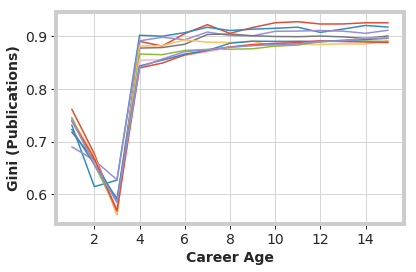

plot_cohort_size_gini_cor
unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


,cohort_start_year,cohort_size,age,criterion,mean,std,sem,median,mean_f,median_f,std_f,sem_f,mean_m,median_m,std_m,sem_m,mean_n,median_n,std_n,sem_n
0,1970,2951,1,num_pub,0.094092,0.170034,0.00313,1.000000e-07,0.073643,0.0,0.15586,0.011884,0.092835,0.0,0.166096,0.004146,0.098807,0.0,0.176953,0.005164


plot_cohort_means_over_ages


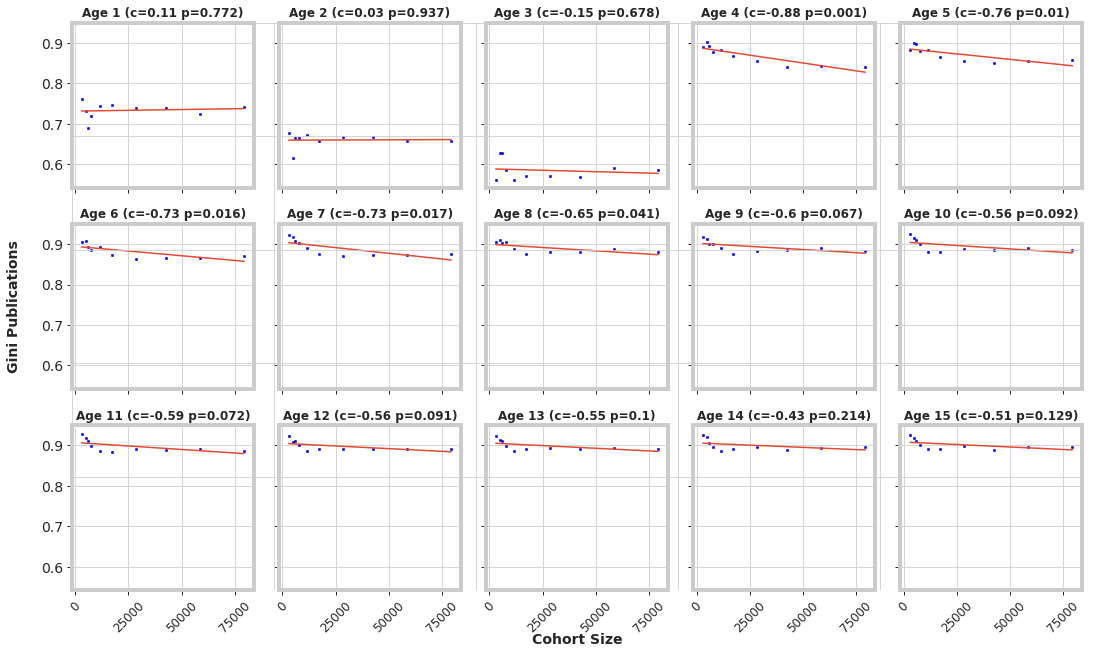

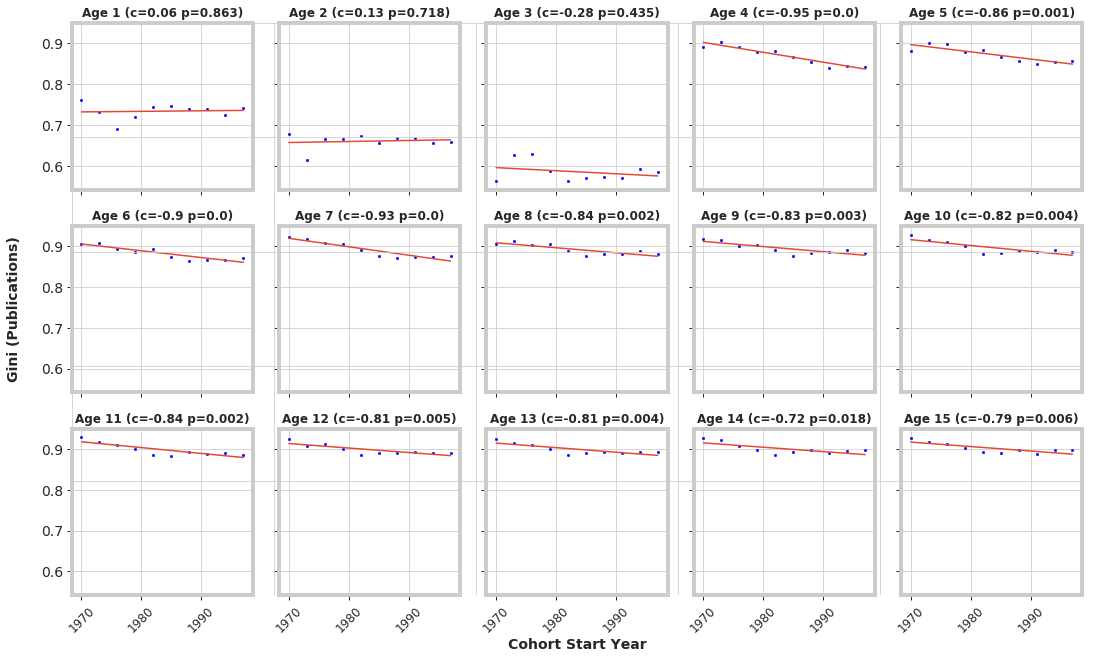

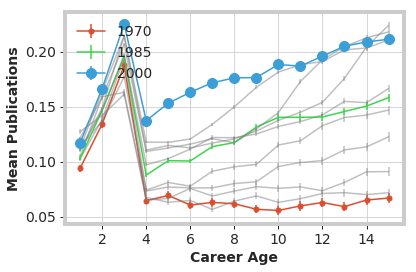

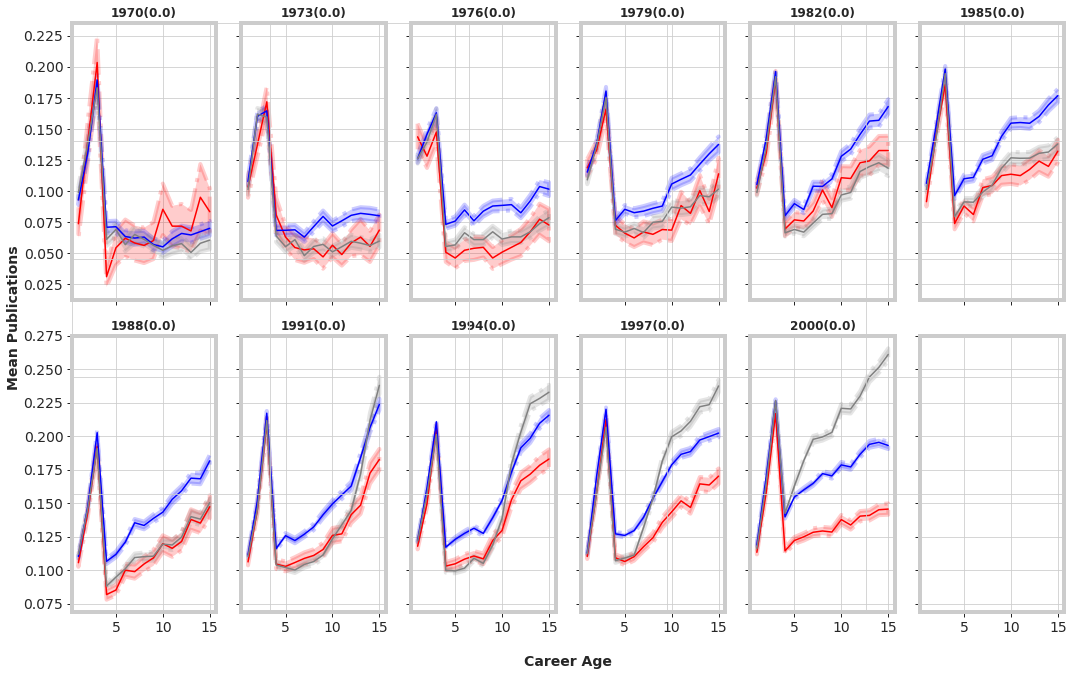

plot_gini [1970, 2000]


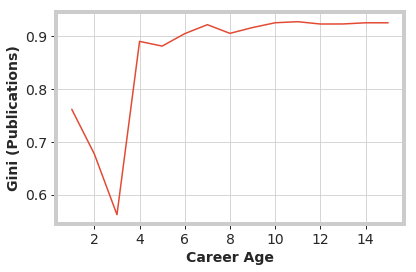

plot_gini [1970, 1980, 1990, 2000]


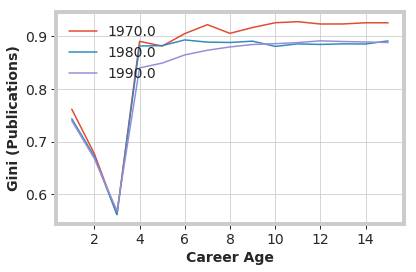

In [16]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications", 
                         authorStartEndCareerData, skip_overlaping_years)  

get_cohort_careerage_df
plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


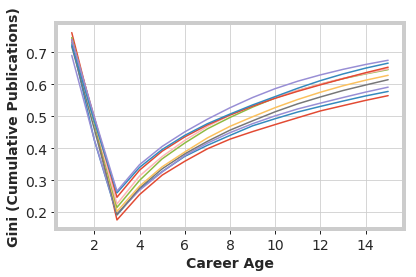

plot_cohort_size_gini_cor
unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


,cohort_start_year,cohort_size,age,criterion,mean,std,sem,median,mean_f,median_f,std_f,sem_f,mean_m,median_m,std_m,sem_m,mean_n,median_n,std_n,sem_n
0,1970,2951,1,cum_num_pub,0.282277,0.510102,0.00939,1.000000e-07,0.22093,0.0,0.467581,0.035653,0.278505,0.0,0.498289,0.012438,0.296422,0.0,0.530858,0.015493


plot_cohort_means_over_ages


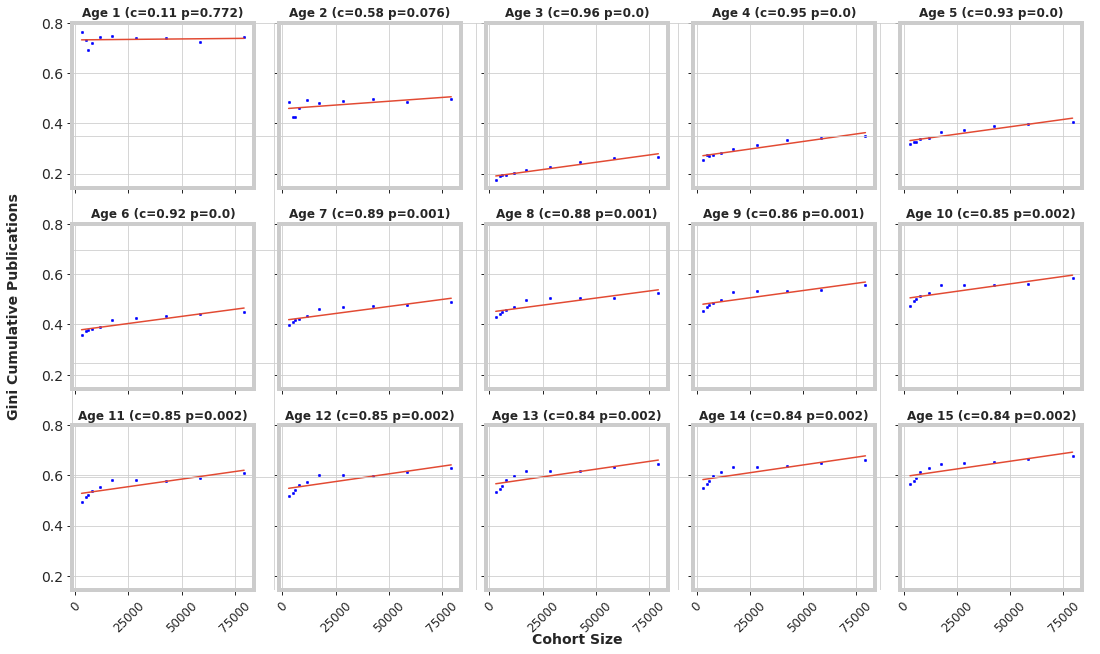

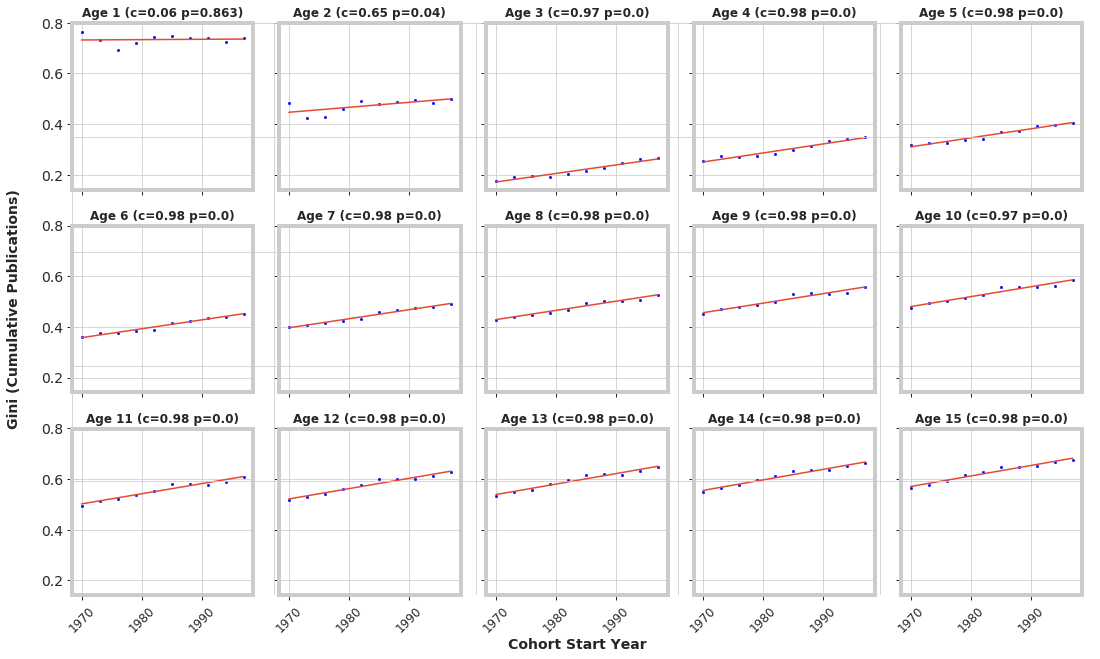

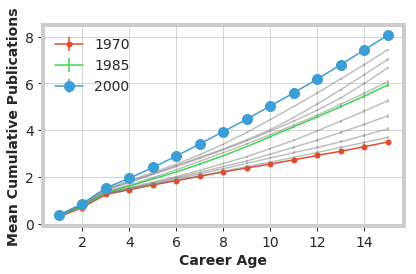

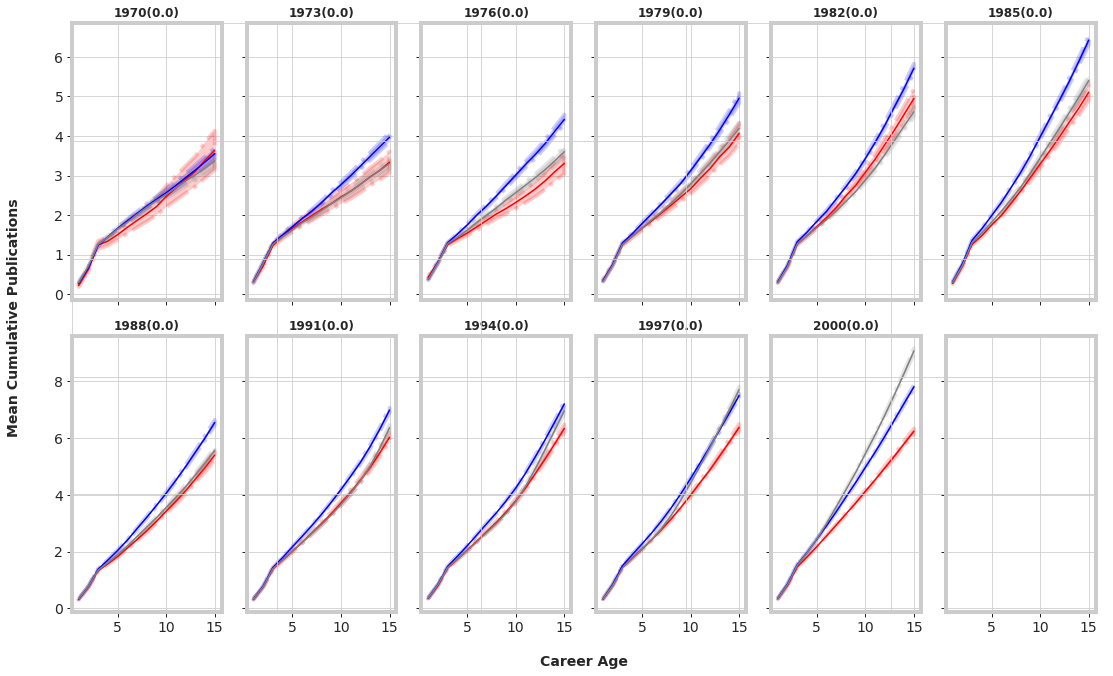

plot_gini [1970, 2000]


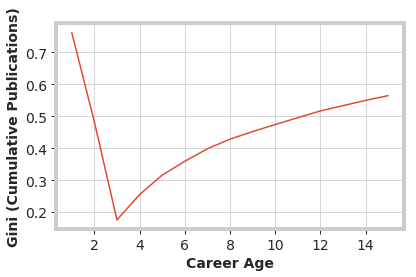

plot_gini [1970, 1980, 1990, 2000]


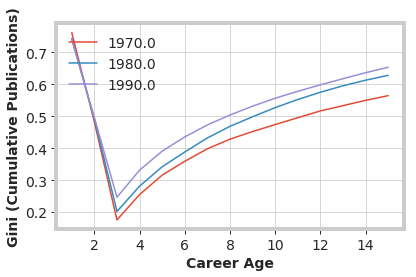

In [17]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_pub", "Cumulative Publications", 
                         authorStartEndCareerData, skip_overlaping_years)  